https://blog.hugo-larcher.com/flight-data-visualisation-with-pandas-and-matplotlib-ebbd13038647



We want to replicate the code provided in the blog post for visualizing flight data using Pandas and Matplotlib, but with the Lufthansa Cargo (LCAG) Flight Schedule available at https://www.lufthansa-cargo.com/de/network/schedule-routings. To achieve this, we need to preprocess the LCAG data to match the format of the Air France data. This involves obtaining the total number of flights per week for a specific routing and collecting the longitude and latitude information for mapping the arrival and departure airports on a map.

To accomplish this, we plan to join the LCAG flight schedule with a dataset (https://datahub.io/core/airport-codes) containing worldwide airport codes along with their corresponding coordinates (longitude and latitude). After the join operation, we can filter out unnecessary columns and proceed to map the schedule on a geographical map for visualization.

In [1]:
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.2/862.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 23.4 MB/s eta 0:00:00


In [104]:
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm

In [105]:
in_filename = "/content/LHcargo_FlightSchedule (3).csv"

In [106]:
# define the expected CSV columns

routes = pd.read_csv(in_filename, na_values=['\\N'], sep=';', skiprows=1)
routes

<ipython-input-106-fba481683390>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  routes = pd.read_csv(in_filename, na_values=['\\N'], sep=';', skiprows=1)


,RowNr,RD,RA,CD,CA,AL,FNR,SNR,DEP,ARR,STD,DDC,STA,ADC,Mo,Tu,We,Th,Fr,Sa,Su,Nbr_flights_p_week,ACtype,ACtypefullname,AG,AGfullname,Start_Op,End_Op
0,1,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5,321,AirbusA321-100/200,W,PAXULD,26-Jan-24,2-Feb-24
1,2,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,NaN,21,321,AirbusA321-100/200,W,PAXULD,8-Jan-24,25-Jan-24
2,3,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5,321,AirbusA321-100/200,W,PAXULD,5-Jan-24,5-Jan-24
3,4,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6,321,AirbusA321-100/200,W,PAXULD,6-Jan-24,6-Jan-24
4,5,EU,EU,DE,DE,LH,LH002,0.0,FRA,HAM,630.0,0.0,735.0,0.0,1.0,2.0,NaN,4.0,NaN,NaN,NaN,7,32A,AirbusA320div.Typ.,W,PAXULD,8-Jan-24,11-Jan-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35400,35401,EU,EU,DE,TR,XQ,XQ997,0.0,MUC,ADB,1010.0,0.0,1455.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6,73H,Boeing737-800(winglets)pax,O,Others,20-Jan-24,27-Jan-24
35401,35402,EU,EU,DE,TR,XQ,XQ997,0.0,MUC,ADB,1010.0,0.0,1455.0,0.0,1.0,NaN,NaN,4.0,NaN,NaN,NaN,5,7M8,BOEING737MAX8,O,Others,22-Jan-24,25-Jan-24
35402,35403,EU,EU,DE,TR,XQ,XQ997,0.0,MUC,ADB,1010.0,0.0,1455.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5,73H,Boeing737-800(winglets)pax,O,Others,5-Jan-24,5-Jan-24
35403,35404,EU,EU,DE,TR,XQ,XQ997,0.0,MUC,ADB,1010.0,0.0,1455.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7,73H,Boeing737-800(winglets)pax,O,Others,7-Jan-24,7-Jan-24


In [6]:
#the first df does not have longitude and coordinatees with the airport names which we need to plot
# the airports on a map. So we join it with another df that has all airport coordinates of the entire world

In [107]:
# Read the CSV file into a DataFrame
df_airports = pd.read_csv('/content/airport-codes_csv (1).csv')

# Display the first few rows of the DataFrame to understand its structure
df_airports

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"
...,...,...,...,...,...,...,...,...,...,...,...,...
57416,ZYYK,medium_airport,Yingkou Lanqi Airport,0.0,AS,CN,CN-21,Yingkou,ZYYK,YKH,NaN,"122.3586, 40.542524"
57417,ZYYY,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,CN-21,Shenyang,ZYYY,NaN,NaN,"123.49600219726562, 41.784400939941406"
57418,ZZ-0001,heliport,Sealand Helipad,40.0,EU,GB,GB-ENG,Sealand,NaN,NaN,NaN,"1.4825, 51.894444"
57419,ZZ-0002,small_airport,Glorioso Islands Airstrip,11.0,AF,TF,TF-U-A,Grande Glorieuse,NaN,NaN,NaN,"47.296388888900005, -11.584277777799999"


In [108]:
# Rename the 'coordinates' column to 'XYcoordinates'
df_airports = df_airports.rename(columns={'coordinates': 'XYcoordinates'})

# Display the resulting DataFrame
df_airports

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,XYcoordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"
...,...,...,...,...,...,...,...,...,...,...,...,...
57416,ZYYK,medium_airport,Yingkou Lanqi Airport,0.0,AS,CN,CN-21,Yingkou,ZYYK,YKH,NaN,"122.3586, 40.542524"
57417,ZYYY,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,CN-21,Shenyang,ZYYY,NaN,NaN,"123.49600219726562, 41.784400939941406"
57418,ZZ-0001,heliport,Sealand Helipad,40.0,EU,GB,GB-ENG,Sealand,NaN,NaN,NaN,"1.4825, 51.894444"
57419,ZZ-0002,small_airport,Glorioso Islands Airstrip,11.0,AF,TF,TF-U-A,Grande Glorieuse,NaN,NaN,NaN,"47.296388888900005, -11.584277777799999"


In [109]:
# Assuming 'coordinates' is the correct column name, proceed with the split
if 'XYcoordinates' in df_airports.columns:
    # Split the 'coordinates' column into 'longitude' and 'latitude'
    df_airports[['longitude', 'latitude']] = df_airports['XYcoordinates'].str.split(', ', expand=True)

    # Convert the 'longitude' and 'latitude' columns to numeric
    df_airports['latitude'] = pd.to_numeric(df_airports['latitude'])
    df_airports['longitude'] = pd.to_numeric(df_airports['longitude'])

    # Drop the original 'coordinates' column if needed
    df_airports = df_airports.drop('XYcoordinates', axis=1)

    # Display the resulting DataFrame
    df_airports
else:
    print("Column 'coordinates' not found in the DataFrame.")

In [110]:
df_airports

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,longitude,latitude
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,-74.933601,40.070801
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,-101.473911,38.704022
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,-151.695999,59.949200
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,-86.770302,34.864799
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,-91.254898,35.608700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57416,ZYYK,medium_airport,Yingkou Lanqi Airport,0.0,AS,CN,CN-21,Yingkou,ZYYK,YKH,NaN,122.358600,40.542524
57417,ZYYY,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,CN-21,Shenyang,ZYYY,NaN,NaN,123.496002,41.784401
57418,ZZ-0001,heliport,Sealand Helipad,40.0,EU,GB,GB-ENG,Sealand,NaN,NaN,NaN,1.482500,51.894444
57419,ZZ-0002,small_airport,Glorioso Islands Airstrip,11.0,AF,TF,TF-U-A,Grande Glorieuse,NaN,NaN,NaN,47.296389,-11.584278


In [111]:
# Filter rows based on the specified conditions. Keep only airports for ease of joining
df_airports = df_airports[df_airports['type'].isin(['medium_airport', 'large_airport'])]

In [112]:
df_airports

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,longitude,latitude
6220,5A8,medium_airport,Aleknagik / New Airport,66.0,NaN,US,US-AK,Aleknagik,5A8,WKK,5A8,-158.617996,59.282600
10464,AF-0005,medium_airport,Khost International Airport (U.C.),4204.0,AS,AF,AF-KHO,Khost,NaN,NaN,NaN,69.807340,33.284605
10489,AGGH,medium_airport,Honiara International Airport,28.0,OC,SB,SB-CT,Honiara,AGGH,HIR,NaN,160.054993,-9.428000
10494,AGGM,medium_airport,Munda Airport,10.0,OC,SB,SB-WE,NaN,AGGM,MUA,NaN,157.263000,-8.327970
10516,AHJ,medium_airport,Hongyuan Airport,11600.0,AS,CN,CN-51,Aba,ZUHY,AHJ,NaN,102.352240,32.531540
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57413,ZYTN,medium_airport,Tonghua Sanyuanpu Airport,1200.0,AS,CN,CN-22,Tonghua,ZYTN,TNH,NaN,125.703333,42.253889
57414,ZYTX,large_airport,Taoxian Airport,198.0,AS,CN,CN-21,Shenyang,ZYTX,SHE,NaN,123.483002,41.639801
57415,ZYYJ,medium_airport,Yanji Chaoyangchuan Airport,624.0,AS,CN,CN-22,Yanji,ZYYJ,YNJ,NaN,129.451004,42.882801
57416,ZYYK,medium_airport,Yingkou Lanqi Airport,0.0,AS,CN,CN-21,Yingkou,ZYYK,YKH,NaN,122.358600,40.542524


In [113]:
routes

,RowNr,RD,RA,CD,CA,AL,FNR,SNR,DEP,ARR,STD,DDC,STA,ADC,Mo,Tu,We,Th,Fr,Sa,Su,Nbr_flights_p_week,ACtype,ACtypefullname,AG,AGfullname,Start_Op,End_Op
0,1,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5,321,AirbusA321-100/200,W,PAXULD,26-Jan-24,2-Feb-24
1,2,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,NaN,21,321,AirbusA321-100/200,W,PAXULD,8-Jan-24,25-Jan-24
2,3,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5,321,AirbusA321-100/200,W,PAXULD,5-Jan-24,5-Jan-24
3,4,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6,321,AirbusA321-100/200,W,PAXULD,6-Jan-24,6-Jan-24
4,5,EU,EU,DE,DE,LH,LH002,0.0,FRA,HAM,630.0,0.0,735.0,0.0,1.0,2.0,NaN,4.0,NaN,NaN,NaN,7,32A,AirbusA320div.Typ.,W,PAXULD,8-Jan-24,11-Jan-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35400,35401,EU,EU,DE,TR,XQ,XQ997,0.0,MUC,ADB,1010.0,0.0,1455.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6,73H,Boeing737-800(winglets)pax,O,Others,20-Jan-24,27-Jan-24
35401,35402,EU,EU,DE,TR,XQ,XQ997,0.0,MUC,ADB,1010.0,0.0,1455.0,0.0,1.0,NaN,NaN,4.0,NaN,NaN,NaN,5,7M8,BOEING737MAX8,O,Others,22-Jan-24,25-Jan-24
35402,35403,EU,EU,DE,TR,XQ,XQ997,0.0,MUC,ADB,1010.0,0.0,1455.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5,73H,Boeing737-800(winglets)pax,O,Others,5-Jan-24,5-Jan-24
35403,35404,EU,EU,DE,TR,XQ,XQ997,0.0,MUC,ADB,1010.0,0.0,1455.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7,73H,Boeing737-800(winglets)pax,O,Others,7-Jan-24,7-Jan-24


In [114]:
###continue here Elena, the exceeds the allowed memory


# Perform a left join based on 'iata_code'
df_result = pd.merge(routes, df_airports, how='left', left_on=['DEP'], right_on=['iata_code'])
df_result = pd.merge(df_result, df_airports, how='left', left_on=['ARR'], right_on=['iata_code'])

pd.set_option('display.max_columns', None)
# Display the resulting DataFrame
df_result

,RowNr,RD,RA,CD,CA,AL,FNR,SNR,DEP,ARR,STD,DDC,STA,ADC,Mo,Tu,We,Th,Fr,Sa,Su,Nbr_flights_p_week,ACtype,ACtypefullname,AG,AGfullname,Start_Op,End_Op,ident_x,type_x,name_x,elevation_ft_x,continent_x,iso_country_x,iso_region_x,municipality_x,gps_code_x,iata_code_x,local_code_x,longitude_x,latitude_x,ident_y,type_y,name_y,elevation_ft_y,continent_y,iso_country_y,iso_region_y,municipality_y,gps_code_y,iata_code_y,local_code_y,longitude_y,latitude_y
0,1,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5,321,AirbusA321-100/200,W,PAXULD,26-Jan-24,2-Feb-24,EDDH,large_airport,Hamburg Airport,53.0,EU,DE,DE-HH,Hamburg,EDDH,HAM,NaN,9.988230,53.630402,EDDF,large_airport,Frankfurt am Main Airport,364.0,EU,DE,DE-HE,Frankfurt am Main,EDDF,FRA,NaN,8.570556,50.033333
1,2,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,NaN,21,321,AirbusA321-100/200,W,PAXULD,8-Jan-24,25-Jan-24,EDDH,large_airport,Hamburg Airport,53.0,EU,DE,DE-HH,Hamburg,EDDH,HAM,NaN,9.988230,53.630402,EDDF,large_airport,Frankfurt am Main Airport,364.0,EU,DE,DE-HE,Frankfurt am Main,EDDF,FRA,NaN,8.570556,50.033333
2,3,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5,321,AirbusA321-100/200,W,PAXULD,5-Jan-24,5-Jan-24,EDDH,large_airport,Hamburg Airport,53.0,EU,DE,DE-HH,Hamburg,EDDH,HAM,NaN,9.988230,53.630402,EDDF,large_airport,Frankfurt am Main Airport,364.0,EU,DE,DE-HE,Frankfurt am Main,EDDF,FRA,NaN,8.570556,50.033333
3,4,EU,EU,DE,DE,LH,LH001,0.0,HAM,FRA,600.0,0.0,710.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6,321,AirbusA321-100/200,W,PAXULD,6-Jan-24,6-Jan-24,EDDH,large_airport,Hamburg Airport,53.0,EU,DE,DE-HH,Hamburg,EDDH,HAM,NaN,9.988230,53.630402,EDDF,large_airport,Frankfurt am Main Airport,364.0,EU,DE,DE-HE,Frankfurt am Main,EDDF,FRA,NaN,8.570556,50.033333
4,5,EU,EU,DE,DE,LH,LH002,0.0,FRA,HAM,630.0,0.0,735.0,0.0,1.0,2.0,NaN,4.0,NaN,NaN,NaN,7,32A,AirbusA320div.Typ.,W,PAXULD,8-Jan-24,11-Jan-24,EDDF,large_airport,Frankfurt am Main Airport,364.0,EU,DE,DE-HE,Frankfurt am Main,EDDF,FRA,NaN,8.570556,50.033333,EDDH,large_airport,Hamburg Airport,53.0,EU,DE,DE-HH,Hamburg,EDDH,HAM,NaN,9.988230,53.630402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508744,END#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,ZYYY,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,CN-21,Shenyang,ZYYY,NaN,NaN,123.496002,41.784401,YPED,medium_airport,RAAF Base Edinburgh,67.0,OC,AU,AU-SA,Adelaide,YPED,NaN,NaN,138.621002,-34.702499
508745,END#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,ZYYY,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,CN-21,Shenyang,ZYYY,NaN,NaN,123.496002,41.784401,Z19O,medium_airport,Wujah Al Hajar Air Base,840.0,AS,LB,LB-AS,Hamat,NaN,NaN,Z19O,35.680096,34.281226
508746,END#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,ZYYY,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,CN-21,Shenyang,ZYYY,NaN,NaN,123.496002,41.784401,ZBBB,medium_airport,Beijing Xijiao Airport,NaN,AS,CN,CN-11,Beijing,ZBBB,NaN,NaN,116.257004,39.960800
508747,END#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,ZYYY,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,CN-21,Shenyang,ZYYY,NaN,NaN,123.496002,41.784401,ZKSC,medium_airport,Sunchon Air Base,141.0,AS,KP,KP-02,Sunchon,ZKSC,NaN,NaN,125.894997,39.415699


In [115]:
#keep only the necessary columns and rename them

# Specify the columns you want to include in the new DataFrame
selected_columns = ['Nbr_flights_p_week', 'iata_code_x', 'latitude_x','longitude_x','iata_code_y','iata_code_y','latitude_y','longitude_y']

# Create a new DataFrame with only the specified columns
new_df = df_result[selected_columns].copy()

# Display the new DataFrame
new_df

,Nbr_flights_p_week,iata_code_x,latitude_x,longitude_x,iata_code_y,iata_code_y,latitude_y,longitude_y
0,5,HAM,53.630402,9.988230,FRA,FRA,50.033333,8.570556
1,21,HAM,53.630402,9.988230,FRA,FRA,50.033333,8.570556
2,5,HAM,53.630402,9.988230,FRA,FRA,50.033333,8.570556
3,6,HAM,53.630402,9.988230,FRA,FRA,50.033333,8.570556
4,7,FRA,50.033333,8.570556,HAM,HAM,53.630402,9.988230
...,...,...,...,...,...,...,...,...
508744,0,NaN,41.784401,123.496002,NaN,NaN,-34.702499,138.621002
508745,0,NaN,41.784401,123.496002,NaN,NaN,34.281226,35.680096
508746,0,NaN,41.784401,123.496002,NaN,NaN,39.960800,116.257004
508747,0,NaN,41.784401,123.496002,NaN,NaN,39.415699,125.894997


In [116]:
# Drop rows with missing values
routes = new_df.dropna()

# Display the cleaned DataFrame
routes

,Nbr_flights_p_week,iata_code_x,latitude_x,longitude_x,iata_code_y,iata_code_y,latitude_y,longitude_y
0,5,HAM,53.630402,9.988230,FRA,FRA,50.033333,8.570556
1,21,HAM,53.630402,9.988230,FRA,FRA,50.033333,8.570556
2,5,HAM,53.630402,9.988230,FRA,FRA,50.033333,8.570556
3,6,HAM,53.630402,9.988230,FRA,FRA,50.033333,8.570556
4,7,FRA,50.033333,8.570556,HAM,HAM,53.630402,9.988230
...,...,...,...,...,...,...,...,...
35400,11,MUC,48.353802,11.786100,ADB,ADB,38.292400,27.157000
35401,6,MUC,48.353802,11.786100,ADB,ADB,38.292400,27.157000
35402,5,MUC,48.353802,11.786100,ADB,ADB,38.292400,27.157000
35403,5,MUC,48.353802,11.786100,ADB,ADB,38.292400,27.157000


In [119]:
!pip install spherical_geometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.2 MB/s eta 0:00:00


GeodError: inv_intermediate: npts and del_s are mutually exclusive, only one of them must be != 0.

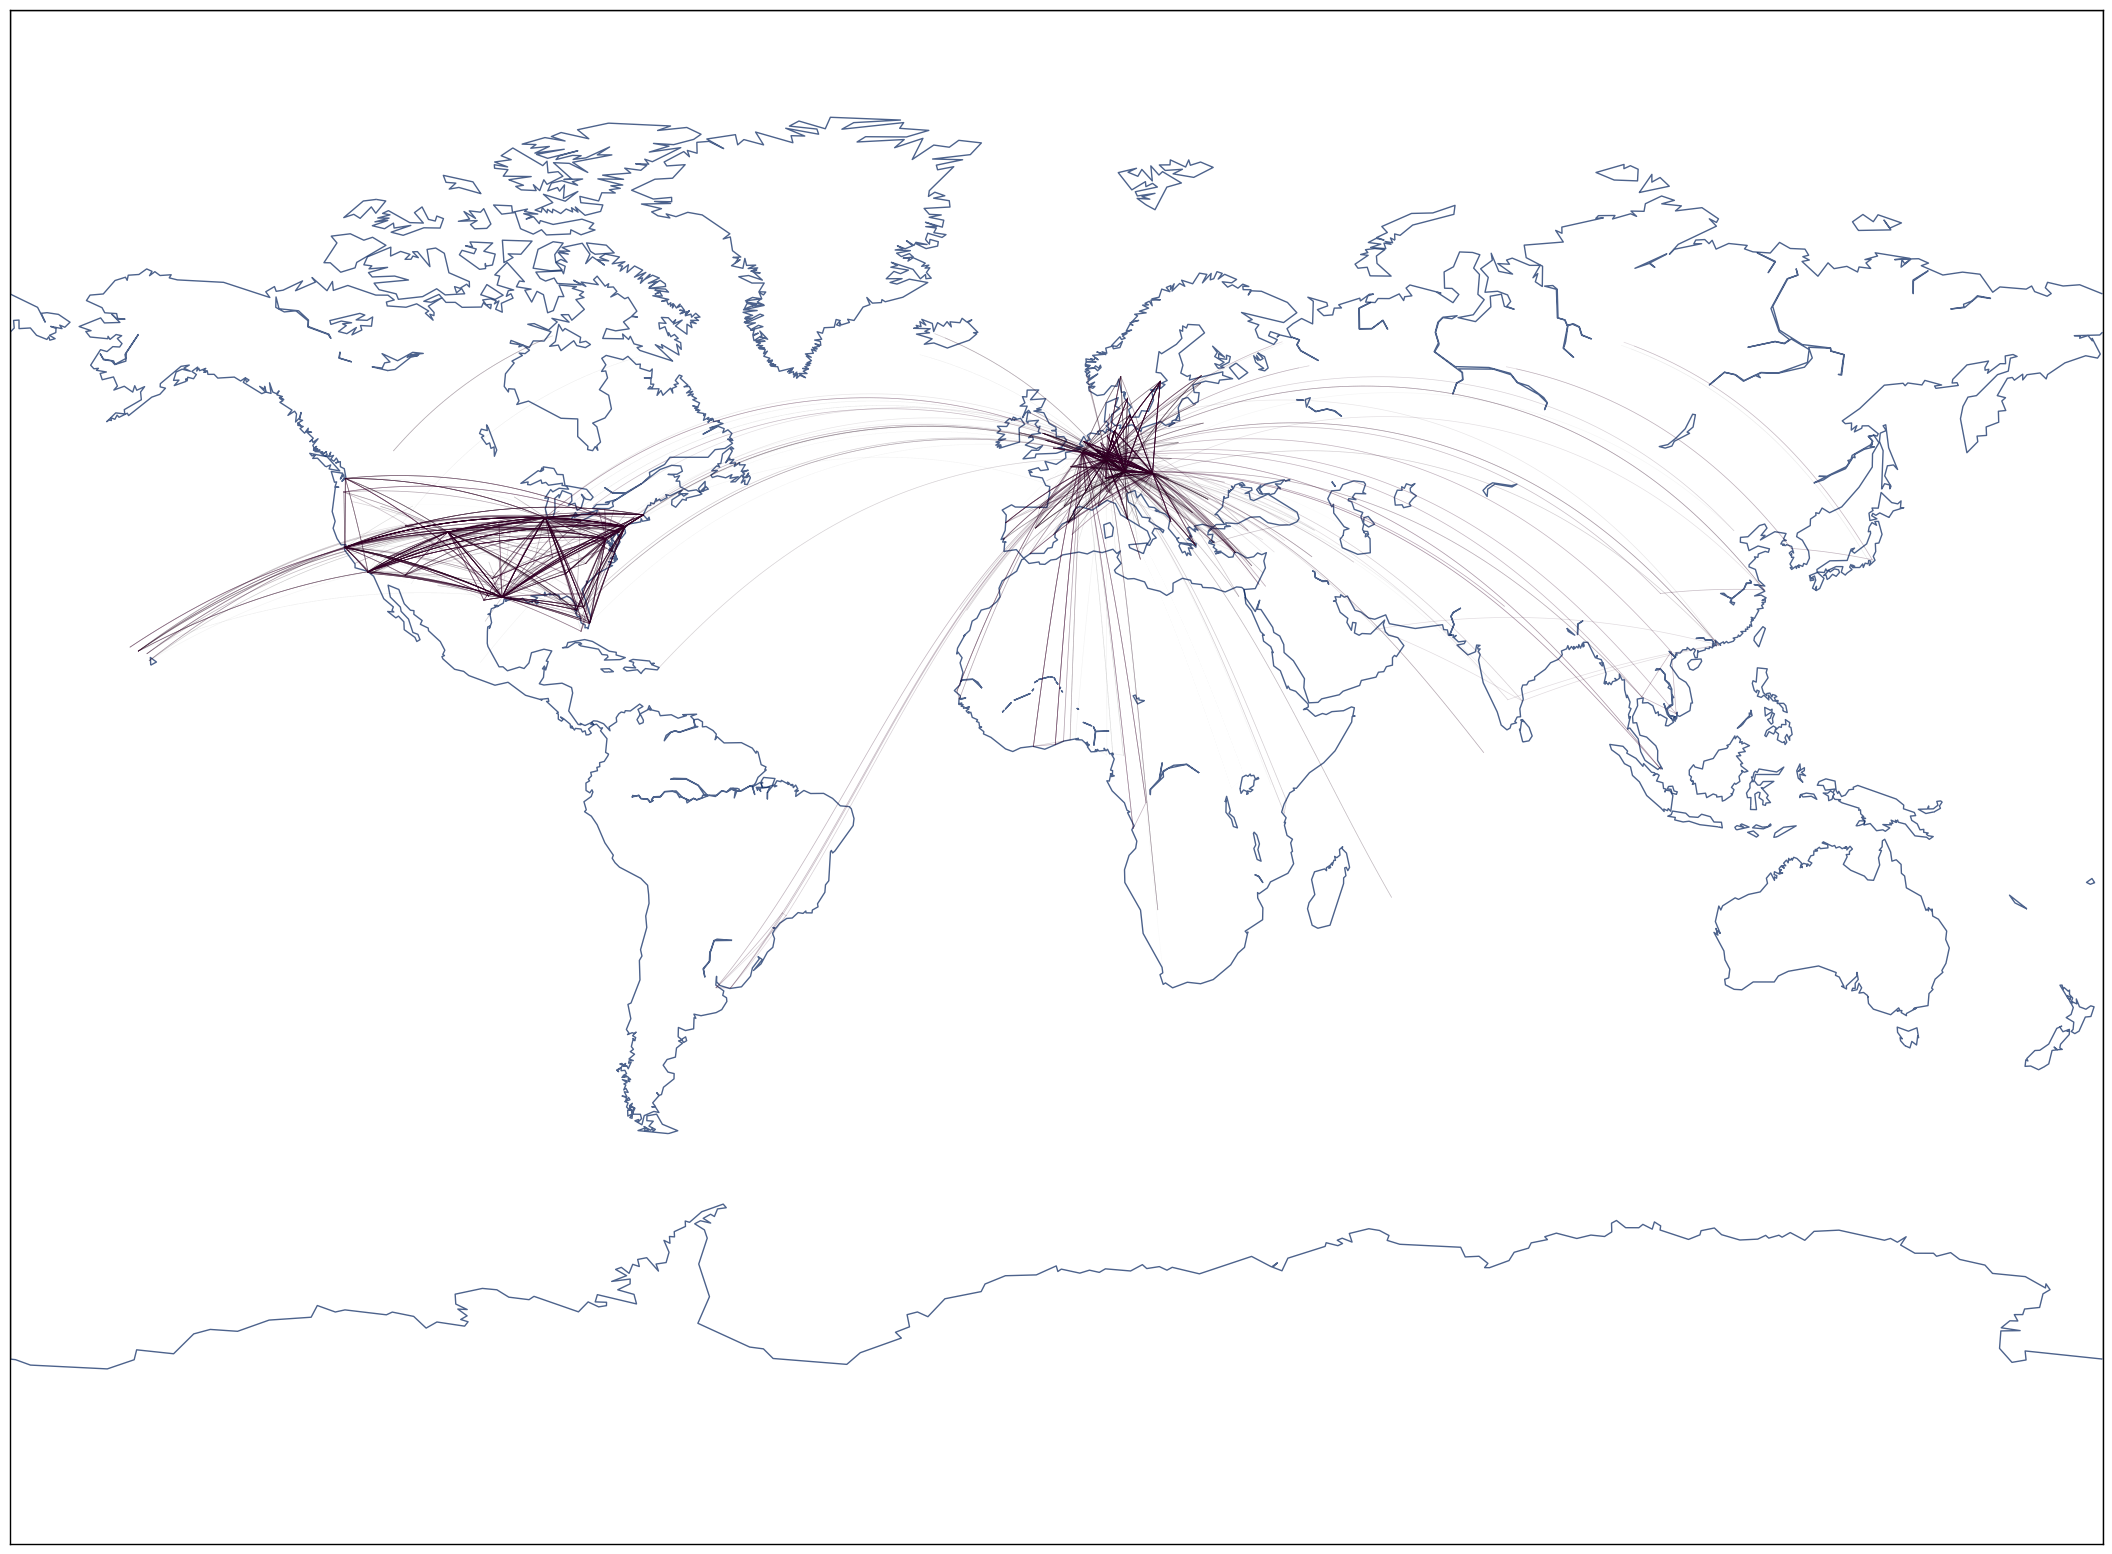

In [134]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm
import numpy as np
from spherical_geometry.polygon import SphericalPolygon
import spherical_geometry.vector as sgv



def plot_map(in_filename, color_mode='screen',
             out_filename='flights_map_mpl.png', absolute=False):
    """Plots the given CSV data files use matplotlib basemap and saves it to
    a PNG file.
    Args:
        in_filename: Filename of the CSV containing the data points.
        out_filename: Output image filename
        color_mode: Use 'screen' if you intend to use the visualisation for
                    on screen display. Use 'print' to save the visualisation
                    with printer-friendly colors.
        absolute: set to True if you want coloring to depend on your dataset
                  parameter value (ie for comparison).
                  When set to false, each coordinate pair gets a different
                  color.
    """

    if color_mode == 'screen':
        bg_color = (1.0, 1.0, 1.0, 1.0)  # Set background color to white
        coast_color = (0/255.0, 32/255.0, 91/255.0, 0.7)
        color_list = [(0.0, 0.0, 0.0, 0.0),
                      (204/255.0, 0, 153/255.0, 0.6),
                      (255/255.0, 204/255.0, 230/255.0, 1.0)]
    else:
        bg_color = (1.0, 1.0, 1.0, 1.0)  # Set background color to white
        coast_color = (10.0/255.0, 10.0/255.0, 10/255.0, 0.8)
        color_list = [(1.0, 1.0, 1.0, 0.0),
                      (255/255.0, 204/255.0, 230/255.0, 1.0),
                      (204/255.0, 0, 153/255.0, 0.6)
                      ]

    # define the expected CSV columns
    CSV_COLS = ('Nbr_flights_p_week', 'iata_code_x', 'latitude_x','longitude_x','iata_code_y','iata_code_y','latitude_y','longitude_y')


    num_routes = len(routes.index)

    # normalize the dataset for color scale
    norm = PowerNorm(0.3, routes['Nbr_flights_p_week'].min(),
                     routes['Nbr_flights_p_week'].max())
    # norm = Normalize(routes['Nbr_flights_p_week'].min(), routes['Nbr_flights_p_week'].max())

    # create a linear color scale with enough colors
    if absolute:
        n = routes['Nbr_flights_p_week'].max()
    else:
        n = num_routes
    cmap = LinearSegmentedColormap.from_list('cmap_flights', color_list,  N=n)




    # create the map and draw country boundaries
    plt.figure(figsize=(27, 20))
    m = Basemap(projection='mill', lon_0=0)
    m.drawcoastlines(color=coast_color, linewidth=1.0)
    m.fillcontinents(color=bg_color, lake_color=bg_color)
    m.drawmapboundary(fill_color=bg_color)

    # plot each route with its color depending on the number of flights
    for i, route in enumerate(routes.sort_values(by='Nbr_flights_p_week',
                              ascending=True).iterrows()):
        route = route[1]
        if absolute:
            color = cmap(norm(int(route['Nbr_flights_p_week'])))
        else:
            color = cmap(i * 1.0 / num_routes)

        line, = m.drawgreatcircle(route['longitude_x'], route['latitude_x'],
                                  route['longitude_y'], route['latitude_y'],
                                  linewidth=0.5, color=color)
        # if the path wraps the image, basemap plots a nasty line connecting
        # the points at the opposite border of the map.
        # we thus detect path that are bigger than 30km and split them
        # by adding a NaN
        path = line.get_path()
        cut_point, = np.where(np.abs(np.diff(path.vertices[:, 0])) > 30000e3)
        if len(cut_point) > 0:
            cut_point = cut_point[0]
            vertices = np.concatenate([path.vertices[:cut_point, :],
                                      [[np.nan, np.nan]],
                                      path.vertices[cut_point+1:, :]])
            path.codes = None  # treat vertices as a serie of line segments
            path.vertices = vertices

    # save the map
    plt.savefig(out_filename, format='png', bbox_inches='tight')

if __name__ == '__main__':

    # use 'screen' color mode for on-screen display. Use 'print' if you intend
    # to print the map
  plot_map('data.csv', 'screen', absolute=False)


In [136]:
data.csv

NameError: name 'data' is not defined